In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [3]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
# sys_model = NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)
sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [ ]:
x_train, y_train = utils.generate_data(sys_true, num_trajectories=1000, seq_len=10)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=100)

full_train_dataset = TensorDataset(x_train, y_train)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
bayesian_knet = NN_models.BayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10, output_layer_multiplier=4,num_gru_layers=2).to(device)
utils.train_bkn(
    model=bayesian_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=100, 
    lr=1e-5, 
    J_samples=5, 
    final_beta=0.5,
    early_stopping_patience=30
)

Epoch [5/100], Train Loss: 0.204835, Val Loss: 0.366500
  Learned p: p1=0.1378, p2=0.1837
Epoch [10/100], Train Loss: 0.196213, Val Loss: 0.356753
  Learned p: p1=0.1378, p2=0.1837
Epoch [15/100], Train Loss: 0.191596, Val Loss: 0.346550
  Learned p: p1=0.1378, p2=0.1837
Epoch [20/100], Train Loss: 0.178734, Val Loss: 0.336060
  Learned p: p1=0.1378, p2=0.1837
Epoch [25/100], Train Loss: 0.175065, Val Loss: 0.328930
  Learned p: p1=0.1378, p2=0.1837
Epoch [30/100], Train Loss: 0.169241, Val Loss: 0.320263
  Learned p: p1=0.1378, p2=0.1837
Epoch [35/100], Train Loss: 0.167614, Val Loss: 0.312272
  Learned p: p1=0.1378, p2=0.1837
Epoch [40/100], Train Loss: 0.158622, Val Loss: 0.305630
  Learned p: p1=0.1378, p2=0.1837
Epoch [45/100], Train Loss: 0.154519, Val Loss: 0.298689
  Learned p: p1=0.1378, p2=0.1837
Epoch [50/100], Train Loss: 0.149424, Val Loss: 0.294877
  Learned p: p1=0.1378, p2=0.1837
Epoch [55/100], Train Loss: 0.149258, Val Loss: 0.289122
  Learned p: p1=0.1378, p2=0.1837


In [ ]:
ekf = Filters.ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']
P_hat_ekf = ekf_results['P_filtered']


VÝSLEDKY PRO JEDEN TESTOVACÍ BĚH

--- MSE ---
Výsledná MSE pro EKF:              0.1062
Výsledná MSE pro Bayesian KNet:    0.1072
--------------------------------------------------

--- NEES ---
Očekávaná hodnota NEES pro 1D systém: 1.0000
--------------------------------------------------
Průměrný NEES pro EKF:              0.7975
Průměrný NEES pro Bayesian KNet:    10850.1699
--------------------------------------------------


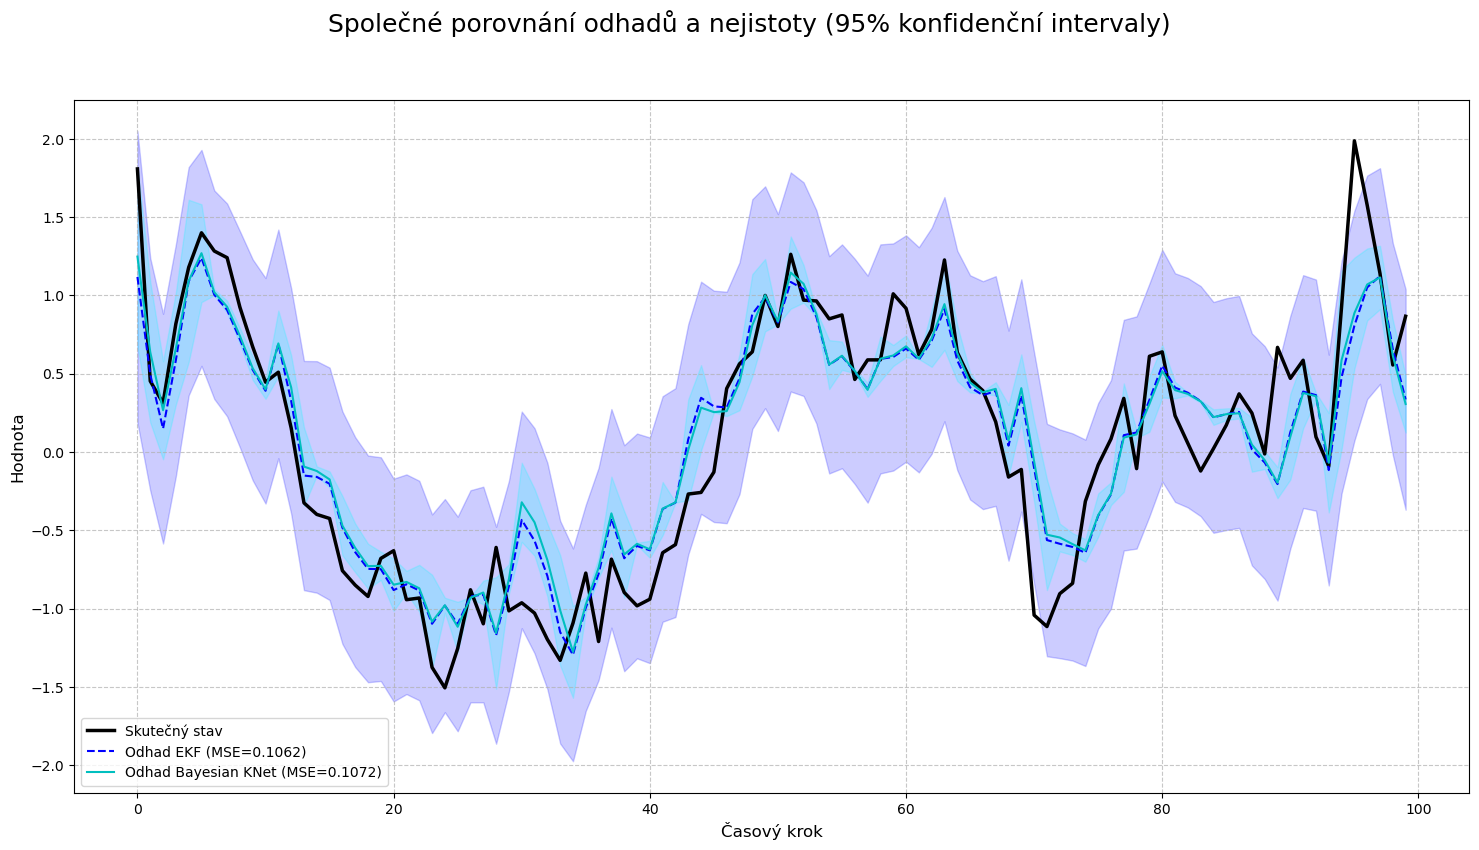

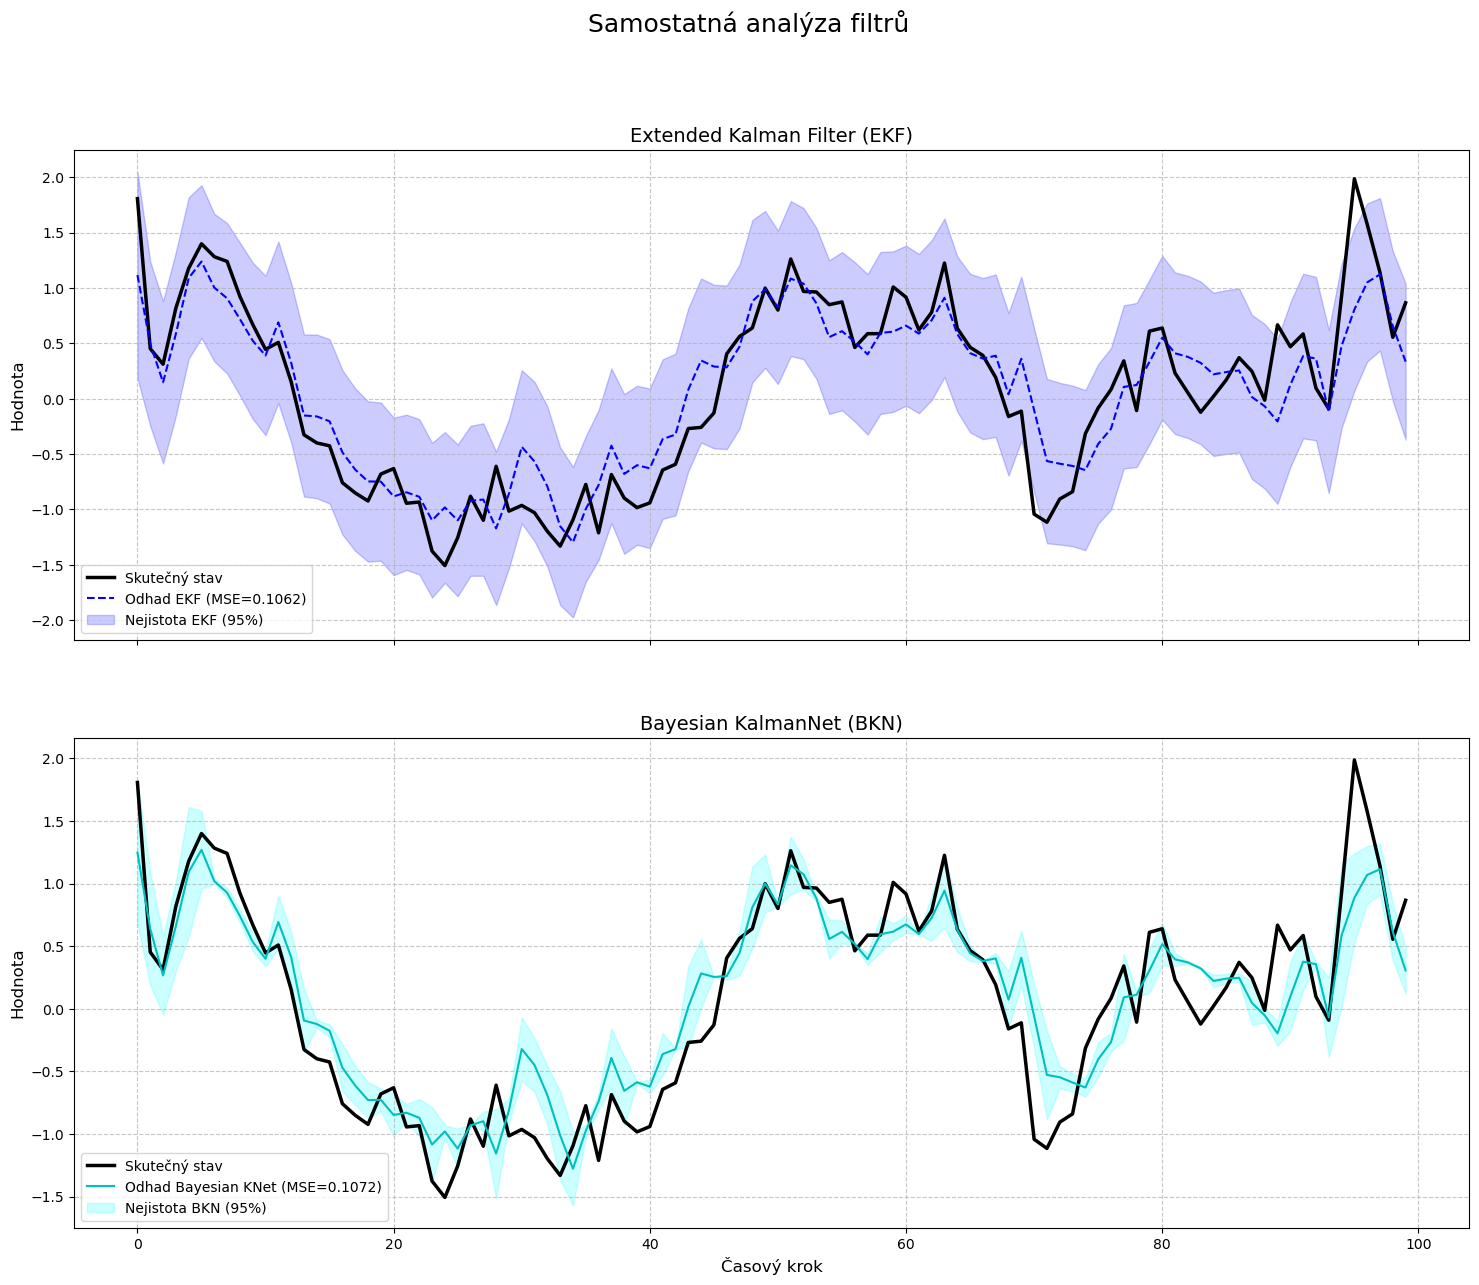

In [ ]:
def calculate_nees(x_true, x_hat, P_hat):
    """
    Vypočítá Normalized Estimation Error Squared (NEES).
    Funguje pro 1D i N-D stav.
    """
    seq_len = x_true.shape[0]
    state_dim = x_true.shape[1]
    nees_samples = torch.zeros(seq_len)

    for t in range(seq_len):
        error = x_true[t] - x_hat[t] # Tvar: [state_dim]
        P_t = P_hat[t] # Tvar: [state_dim] nebo [state_dim, state_dim]

        # Sjednocení tvaru P_t na matici pro obecný výpočet
        if state_dim == 1:
            P_t_matrix = P_t.reshape(1, 1)
        else:
            P_t_matrix = P_t
            
        # Přidání malé hodnoty na diagonálu pro numerickou stabilitu inverze
        P_stable = P_t_matrix + torch.eye(state_dim) * 1e-9
        P_inv = torch.inverse(P_stable)
        
        # Výpočet NEES: e^T * P^-1 * e
        nees_samples[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        
    avg_nees = nees_samples.mean()
    return avg_nees

# Instance MSE loss
mse_criterion = nn.MSELoss()


# Počet vzorků pro odhad nejistoty při vyhodnocení
num_samples_for_prediction = 20

# Přepneme model do evaluačního módu
bayesian_knet.eval()
with torch.no_grad():
    y_test_device = y_test.to(device)
    
    # Aktivace dropoutu vrstvy pro MC sampling
    bayesian_knet.train()
    x_hat_bkn, sigma_bkn,_ = bayesian_knet(y_test_device, num_samples=num_samples_for_prediction)
    bayesian_knet.eval() # Vrátíme model zpět
    
    # Přesun výsledků na CPU pro analýzu
    x_hat_bkn = x_hat_bkn.cpu()
    sigma_bkn = sigma_bkn.cpu()
    
# --- 3. Příprava dat pro porovnání ---
x_true_seq = x_test.squeeze(0).cpu()
x_hat_ekf_seq = x_hat_ekf.cpu()
P_hat_ekf_seq = P_hat_ekf.cpu()
x_hat_bkn_seq = x_hat_bkn.squeeze(0).cpu()
sigma_bkn_seq = sigma_bkn.squeeze(0).cpu()

# --- 4. Kvantitativní porovnání: MSE a ANEES ---

# A) Výpočet MSE
mse_ekf = mse_criterion(x_hat_ekf_seq, x_true_seq)
mse_bkn = mse_criterion(x_hat_bkn_seq, x_true_seq)

print("\n" + "="*50)
print("VÝSLEDKY PRO JEDEN TESTOVACÍ BĚH")
print("="*50)

print("\n--- MSE ---")
print(f"Výsledná MSE pro EKF:              {mse_ekf.item():.4f}")
print(f"Výsledná MSE pro Bayesian KNet:    {mse_bkn.item():.4f}")
print("-" * 50)

# B) Výpočet NEES
avg_nees_ekf = calculate_nees(x_true_seq, x_hat_ekf_seq, P_hat_ekf_seq)
avg_nees_bkn = calculate_nees(x_true_seq, x_hat_bkn_seq, sigma_bkn_seq)

state_dim_for_nees = x_true_seq.shape[1]

print("\n--- NEES ---")
print(f"Očekávaná hodnota NEES pro {state_dim_for_nees}D systém: {state_dim_for_nees:.4f}")
print("-" * 50)
print(f"Průměrný NEES pro EKF:              {avg_nees_ekf.item():.4f}")
print(f"Průměrný NEES pro Bayesian KNet:    {avg_nees_bkn.item():.4f}")
print("-" * 50)

# --- 5. Grafické porovnání ---

# Extrakce dat pro plotování
ekf_mean = x_hat_ekf_seq.squeeze()
ekf_std = torch.sqrt(torch.diagonal(P_hat_ekf_seq, dim1=-2, dim2=-1)).squeeze()

bkn_mean = x_hat_bkn_seq.squeeze()
bkn_std = torch.sqrt(torch.diagonal(sigma_bkn_seq, dim1=-2, dim2=-1)).squeeze()

x_true_plot = x_true_seq.squeeze()
time_steps = range(len(x_true_plot))

fig1, ax1 = plt.subplots(1, 1, figsize=(18, 9))
fig1.suptitle('Společné porovnání odhadů a nejistoty (95% konfidenční intervaly)', fontsize=18)
ax1.plot(x_true_plot, 'k-', linewidth=2.5, label='Skutečný stav')
ax1.plot(ekf_mean, 'b--', label=f'Odhad EKF (MSE={mse_ekf.item():.4f})')
ax1.fill_between(time_steps, ekf_mean - 2 * ekf_std, ekf_mean + 2 * ekf_std, color='blue', alpha=0.2)
ax1.plot(bkn_mean, 'c-', label=f'Odhad Bayesian KNet (MSE={mse_bkn.item():.4f})')
ax1.fill_between(time_steps, bkn_mean - 2 * bkn_std, bkn_mean + 2 * bkn_std, color='cyan', alpha=0.2)
ax1.set_ylabel('Hodnota', fontsize=12)
ax1.set_xlabel('Časový krok', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()
plt.show()

fig2, (ax2, ax3) = plt.subplots(2, 1, figsize=(18, 14), sharex=True)
fig2.suptitle('Samostatná analýza filtrů', fontsize=18)

# EKF
ax2.set_title('Extended Kalman Filter (EKF)', fontsize=14)
ax2.plot(x_true_plot, 'k-', linewidth=2.5, label='Skutečný stav')
ax2.plot(ekf_mean, 'b--', label=f'Odhad EKF (MSE={mse_ekf.item():.4f})')
ax2.fill_between(time_steps, ekf_mean - 2 * ekf_std, ekf_mean + 2 * ekf_std, 
                 color='blue', alpha=0.2, label='Nejistota EKF (95%)')
ax2.set_ylabel('Hodnota', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Bayesian KalmanNet
ax3.set_title('Bayesian KalmanNet (BKN)', fontsize=14)
ax3.plot(x_true_plot, 'k-', linewidth=2.5, label='Skutečný stav')
ax3.plot(bkn_mean, 'c-', label=f'Odhad Bayesian KNet (MSE={mse_bkn.item():.4f})')
ax3.fill_between(time_steps, bkn_mean - 2 * bkn_std, bkn_mean + 2 * bkn_std, 
                 color='cyan', alpha=0.2, label='Nejistota BKN (95%)')
ax3.set_ylabel('Hodnota', fontsize=12)
ax3.set_xlabel('Časový krok', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend()

plt.show()